In [512]:
import plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import numpy as np
import pandas as pd
import scipy

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.tools import FigureFactory as FF
from chart_studio.plotly import plot, iplot
import numpy as np
import pandas as pd
import scipy
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from xgboost import XGBClassifier
import string

In [244]:
df=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [248]:
print('The training dataset has 7613 observations and 5 columns'+str(df.shape))
print('The training dataset has 3263 observations and 4 columns'+str(test.shape))

The training dataset has 7613 observations and 5 columns(7613, 5)
The training dataset has 3263 observations and 4 columns(3263, 4)


The training dataset has 7613 observations and 5 columns

The testing dataset has 3263 observations and 4 columns

In [249]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

- id : a unique identifier for each tweet
- text : the content of the tweet
- location : the location the tweet was sent from (maybe not the real locations)
- keyword : a particular keyword from the tweet (the disaster tag)
- target : 1 means the tweets align with the disaster,otherwise, it is 0.


In [123]:
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [250]:
# check the missing values
df.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.0+ KB


In [252]:
def missing(a,i):
    m=a[i].isnull().value_counts()/a.shape[0]
    return m



In [254]:
print(missing(df,i='keyword'))
print(missing(df,i='location'))
print(missing(test,i='keyword'))
print(missing(test,i='location'))

False    0.991987
True     0.008013
Name: keyword, dtype: float64
False    0.66728
True     0.33272
Name: location, dtype: float64
False    0.992032
True     0.007968
Name: keyword, dtype: float64
False    0.661355
True     0.338645
Name: location, dtype: float64


we may can fill the blank keywords manully or delete;
Training and Testing data both only have 1/3 locations which need pay more attentions

AttributeError: 'list' object has no attribute 'iplot'

In [255]:
#the distribution of target in training
colors=colors = ['lightslategray',] * 2
colors[1] = 'crimson'
trace = go.Bar(
    y = df['target'].value_counts(), text=df['target'].value_counts(), marker_color=colors,width=0.5)

data = [trace]

py.offline.init_notebook_mode()
fig=py.offline.iplot(data, filename='basic-bar')

when target=0, the number of observation=4342;
when target=1, the number of observation=3271

Because the numbers are similar, the dataset is balanced.In order to train the model,
we also need to find the difference between the non-disaster massage and disaster massage.

In [256]:
#lenth of the tweets(1,0)
list=[]
for i in df['text']:
    a=len(i)
    list.append(a)


In [257]:
df1 = pd.concat([df, pd.DataFrame(list)], axis=1)

In [265]:
df1.rename(columns={0: "length"},inplace=True)

In [266]:
###when target==1, the distribution of the length 
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"},
                                            {"type": "bar"}]])
x=df1[df1['target']==1]
y=df1[df1['target']==0]
#trace = go.Histogram(x=x['length'], xbins=dict(start=np.min(x), size=10, end=np.max(x)),
                   #marker=dict(color='rgb(0, 100, 50)'))
# Add bar traces to subplot (1, 1)
fig.add_trace(go.Histogram(x=x['length'], xbins=dict(start=np.min(x), size=10, end=np.max(x)),
                   marker=dict(color='rgb(0, 100, 50)')), row=1, col=1)

fig.add_trace(go.Histogram(x=y['length'], xbins=dict(start=np.min(y), size=10, end=np.max(y)),
                   marker=dict(color='rgb(200, 100, 50)')), row=1, col=2)
# Hide legend
fig.update_layout(
    showlegend=False,
    title_text="the length of disaster|non-disaster text",
    height=500,
    width=800,
)

fig.show()




In [368]:
# let's look at how many words in one twitter
df1['word'] = df1['text'].apply(lambda x: len(str(x).split()))
df1['word'] = df1['text'].apply(lambda x: len(str(x).split()))


In [476]:
##let's compare together
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"},
                                            {"type": "bar"}]])
x=df1[df1['target']==1]
y=df1[df1['target']==0]
#trace = go.Histogram(x=x['length'], xbins=dict(start=np.min(x), size=10, end=np.max(x)),
                   #marker=dict(color='rgb(0, 100, 50)'))
# Add bar traces to subplot (1, 1)
fig.add_trace(go.Histogram(x=x['word'], xbins=dict(start=np.min(x), size=2, end=np.max(x)),
                   marker=dict(color='rgb(0, 100, 50)'),name='disaster'),row=1, col=1)

fig.add_trace(go.Histogram(x=y['word'], xbins=dict(start=np.min(y), size=2, end=np.max(y)),
                   marker=dict(color='rgb(200, 100, 50)'),name='non-disaster'), row=1, col=1)
fig.add_trace(go.Histogram(x=x['length'], xbins=dict(start=np.min(x), size=10, end=np.max(x)),
                   marker=dict(color='rgb(0, 100, 50)'),name='disaster'),row=1, col=2)
fig.add_trace(go.Histogram(x=y['length'], xbins=dict(start=np.min(y), size=10, end=np.max(y)),
                   marker=dict(color='rgb(200, 100, 50)'),name='non-disaster'), row=1, col=2)
# Hide legend
fig.update_layout(
    showlegend=True,
    title_text="the number of words| character in disaster|non-disaster text",
    height=500,
    width=900,
)

fig.show()

In [501]:
###the distribution of the location
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2,
    start_cell="top-left", specs=[[{"type": "bar"}, {"type": "bar"}]],
                     subplot_titles=("the location frequency of disaster-related massage",'the location frequency of non-disaster-related massage'))



x=df1[df1['target']==1]
y=df1[df1['target']==0]
a=x['location'].value_counts()
b=y['location'].value_counts()


fig.add_trace(go.Bar(y=a.head(50).keys(),x=a.head(50),
            marker={'color': a.head(50),'colorscale': 'Viridis'},orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Bar(y=b.head(50).keys(),x=b.head(50),
            marker={'color': b.head(50),'colorscale': 'Viridis'},orientation='h'),
            row=1, col=2)



fig.update_layout( 
    showlegend=False,
         #= x for x in sorted(x['location'].value_counts()),
    title_text="The Location of Disaster|Non-disaster Text",
    height=1500,
    width=1050)

fig.show()

In [292]:

#the unique value in keyword&locations
print(f'Number of unique values in keyword = {df1["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df1["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


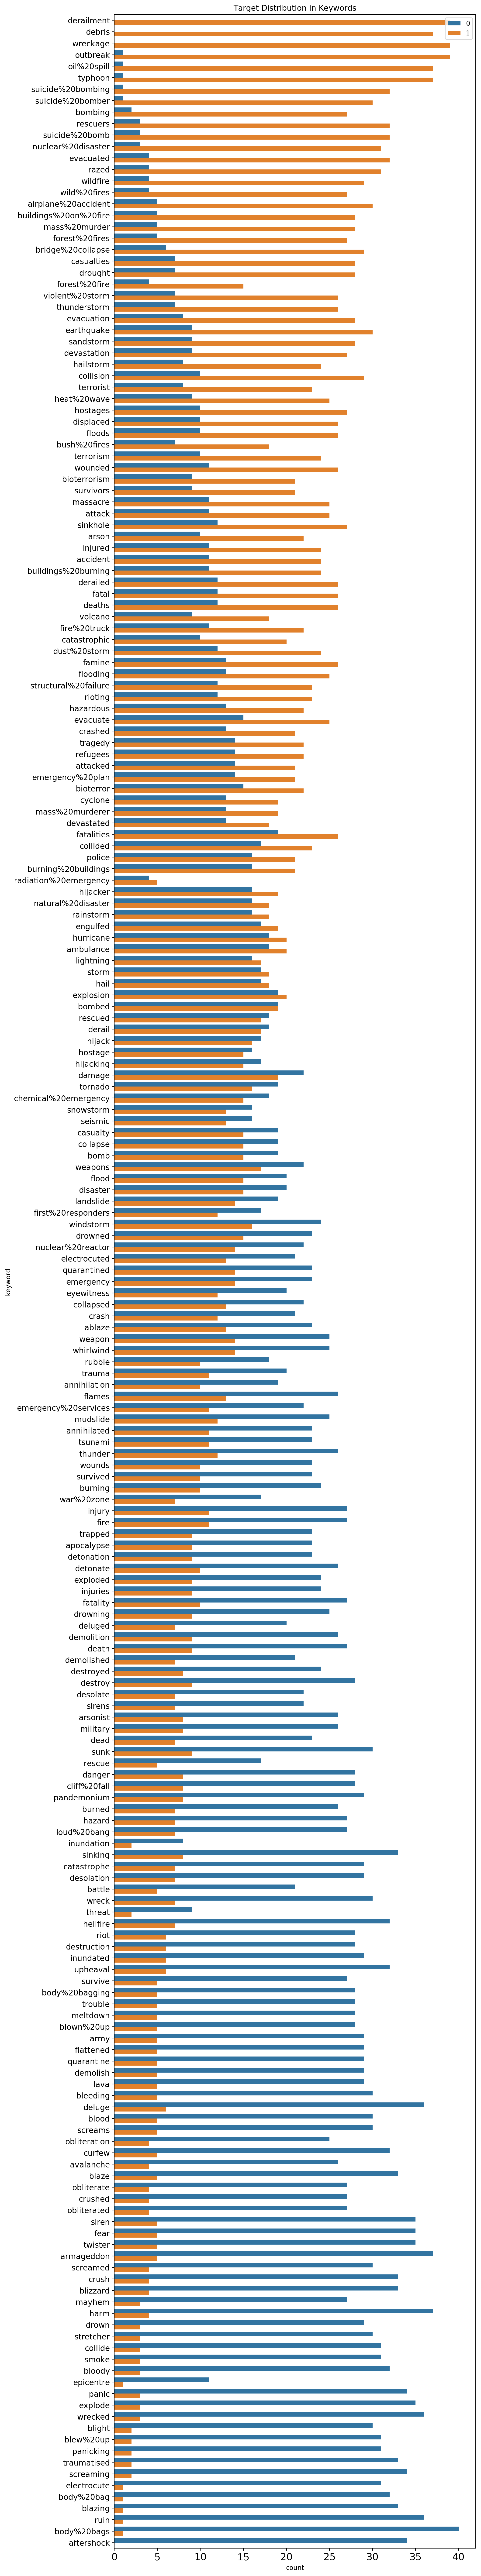

In [585]:
###which keywords has more possibility to have disaster massage
df1['target_mean'] = df1.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(10, 72), dpi=200)

sns.countplot(y=df1.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df1.sort_values(by='target_mean', ascending=False)['target'],
              )

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)

plt.title('Target Distribution in Keywords')

plt.show()



In [682]:

def plot(j):
    fig = make_subplots(rows=1, cols=1,
        start_cell="top-left")

    x=df1[df1['target']==1]
    y=df1[df1['target']==0]
    a=x[j].value_counts()
    b=y[j].value_counts()


    colors = ['lightslategray',] * 2
    colors[1] = 'crimson'
    fig.add_trace(go.Bar(y=a.keys(),x=a,orientation='h',name='1',marker=dict(
        color='rgba(135, 206, 250, 100)'),),row=1, col=1,)
    fig.add_trace(go.Bar(y=a.keys(),x=b[a],orientation='h',name='0',marker=dict(
        color='rgba(200, 0, 250, 50)',opacity=0.6)),row=1, col=1)

    fig.update_layout( 
        showlegend=True,
        height=9000,
        width=850)

    fig.show()


In [683]:
#the distribution of keyword
plot('keyword')

In [669]:

# unique_word_count
df1['unique_word_count'] = df1['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df1['stop_word_count'] = df1['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df1['url_count'] = df1['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# punctuation_count
df1['punctuation_count'] = df1['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df1['hashtag_count'] = df1['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df1['mention_count'] = df1['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

C:\anaconda2\lib\site-packages\pandas\core\series.py:842: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike

